In [18]:
#Dependencies
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from random import choice
from sklearn import svm
from string import ascii_lowercase, digits
from sklearn.ensemble import RandomForestClassifier
import copy
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier


In [45]:
#SVM Code
debugSVM = False;

trainDFRaw = pd.read_csv("train.csv")
testDFRaw = pd.read_csv("test.csv")

pd.set_option('display.max_columns', 24)

rawVals = list(trainDFRaw.columns.values)

showHistograms = False;
if(showHistograms):
  if debugSVM: print(', '.join(str(e) for e in rawVals))
  for c in rawVals[2:]:
    plt1 = trainDFRaw[c].value_counts().plot(kind="bar",title = c)
    plt.show()

def createOneHotNames(df):
  names = {}
  attributes = list(df.columns.values)
  attributes.remove('id')
  attributes.remove('Decision')

  df['Bar'] = df['Bar'].fillna(0)
  df['Coffeehouse'] = df['Coffeehouse'].fillna(0)
  df['Carryaway'] = df['Carryaway'].fillna(0)
  df['Restaurantlessthan20'] = df['Restaurantlessthan20'].fillna(0)
  df['Restaurant20to50'] = df['Restaurant20to50'].fillna(0)

  for a in attributes:
    uniqueColumnValues = list(set(df[a].tolist()));
    chars = ascii_lowercase + digits
    intValues = [''.join(choice(chars) for _ in range(10)) for _ in range(0, len(uniqueColumnValues))]
    names[a] = intValues;
  return names;


def preprocess(df,names):
  isTrain = False;
  if debugSVM: print(df.shape)
  if debugSVM: print(df)
  
  #remove attributes from list that need preprocessing
  attributes = list(df.columns.values)
  attributes.remove('id')
  attributes.remove('Bar')
  attributes.remove('Temperature')
  attributesToOneHot = list(df.columns.values)

  if("Decision" in attributes):
    isTrain = True;
    attributes.remove('Decision')
    attributesToOneHot.remove("Decision")

  #Replace NAN values with most common values
  colsWithNAN = ["Bar","Coffeehouse","Carryaway","Restaurantlessthan20","Restaurant20to50"]

  for c in colsWithNAN:
    df[c].fillna(df[c].value_counts().idxmax(), inplace=True)

  as_ordinal = True;

  #these attributes don't need to be OneHotEncoded
  attributesToOneHot.remove("Distance")
  attributesToOneHot.remove("id")
  attributesToOneHot.remove("Bar")
  attributesToOneHot.remove("Temperature")
  attributesToOneHot.remove("Direction_same")

  #Min-Max Normalization
  IncomeValues = ['$50000 - $62499', '$25000 - $37499', 'Less than $12500', '$75000 - $87499', '$62500 - $74999', '$37500 - $49999', '$87500 - $99999', '$100000 or More', '$12500 - $24999']
  IncomeOrdinal = [5/9               , 3/9               , 0/9                , 7/9                , 6/9                  , 4 /9                , 8  /9           , 9 /9               , 2/9]

  AgeValues = ['31', '46', '36', 'below21', '26', '50plus', '41', '21']
  AgeOrdinal = [4/7, 6/7, 3/7, 0/7     , 2/7, 7/7, 5/7, 1/7]

  CoffeehouseValues = [0.0, 1.0, 2.0, 3.0, 4.0]
  CoffeehouseOrdinal = [0.0, 1.0/4, 2.0/4, 3.0/4, 4.0/4]

  CarryawayValues = [0.0, 1.0, 2.0, 3.0, 4.]
  CarryawayValuesOrdinal = [0.0, 1.0/4, 2.0/4, 3.0/4, 4.0/4]

  Restaurantlessthan20Values = [0.0, 1.0, 2.0, 3.0, 4.0]
  Restaurantlessthan20Ordinal = [0.0, 1.0/4, 2.0/4, 3.0/4, 4.0/4]

  Restaurant20to50Values = [0.0, 1.0, 2.0, 3.0, 4.0]
  Restaurant20to50Ordinal = [0.0, 1.0/4, 2.0/4, 3.0/4, 4.0/4]

  for a in attributes:
    if debugSVM: print(a,":",set(df[a].tolist()))
    if(as_ordinal):
      
      if(a in attributesToOneHot):
        uniqueColumnValues = list(set(df[a].tolist()));
        df[a] = df[a].replace(to_replace=uniqueColumnValues, value=names[a])
    #print(a,"(mod):",set(df[a].tolist()))

  df = df.drop(labels="Bar", axis=1)
  df = df.drop(labels="Temperature", axis=1)
  
  if(isTrain):
    x = df.iloc[:, 2:]
    y = df.iloc[:,1]
  else:
    x = df.iloc[:, 1:]
    y = df.iloc[:,1]

  for a in attributesToOneHot:
    one_hot = pd.get_dummies(x[a])
    x = x.drop(a,axis = 1)
    x = x.join(one_hot)
  return x,y;

names = createOneHotNames(trainDFRaw);
x_train,y_train = preprocess(trainDFRaw,names)
x_test,y_test = preprocess(testDFRaw,names)

if debugSVM: print(x_train.shape)

#run model, then do CV
def testAlgorithm(clf):
  if debugSVM: print(type(clf))
  clf.fit(x_train, y_train)
  pred=clf.predict(x_train)
  if debugSVM: print(accuracy_score(y_train,pred))
  predTest = clf.predict(x_test)
  cv = cross_val_score(clf, x_train, y_train, cv=5)

  if debugSVM: print(mean(cv))
  
  return predTest,mean(cv);

classifiers = []

cvScores = []

#Uncomment if you want to test a variety of hyperparameter settings

#C_range = [.01,.1,1,10,15,20,30,50,75,100,200]
#C_range = [10]
#gamma_range = [1/1000000,1/100000,1/10000,1/1000,1/100,1/10,1,10,100,1000]
#for c in C_range:
#  classifiers.append(svm.SVC(C=c)) #C= 10 gave ~73%

#for c in gamma_range:
#  classifiers.append(svm.SVC(C=10,gamma=c)) #C= 10 gave ~73%

#kernel_range = ['linear', 'poly', 'rbf', 'sigmoid']
#for c in kernel_range:
#  classifiers.append(svm.SVC(C=10,kernel=c)) #C= 10 gave ~73%

classifiers.append(svm.SVC(C=10)) #This is the best model

predList = []

print("Running Classifier(s)")

for c in classifiers:
  pred, cvScore = testAlgorithm(c)
  predList.append(pred)
  cvScores.append(cvScore)

print("CV score:",cvScores)

#Output Test Decision to CSV
for i,p in enumerate(predList):
  output = True;
  if(output):
    predData = {'id': list(range(1, len(p)+1)),
            'Decision': p
            }

    predDF = pd.DataFrame(predData, columns= ['id', 'Decision'])
    predDF.to_csv ('/content/predictions'+str(type(classifiers[i]))+".csv", index = False, header=True)


Running Classifier(s)
CV score: [0.7491160582273134]


In [47]:
#Random Forest

rawVals = list(trainDFRaw.columns.values)

showPlots = False;
if(showPlots):
  gamma_range = [1/1000000,1/100000,1/10000,1/1000,1/100,1/10,1,10,100,1000]
  plt.plot(gamma_range,[.56,.569,.65,.68,.72,.723,.599,.57,.57,.56])
  plt.title('SVM Performance, Gamma Hyperparameter Tuning')
  plt.ylabel('mean 5-fold CV Accuracy')
  plt.xlabel('Gamma parameter')
  plt.xscale('log')
  plt.show()

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ker = ['linear', 'poly', 'rbf', 'sigmoid']
  kerVals = [0.685388845247447, 0.710820895522388, 0.7293794186959937, 0.5767871170463472]
  plt.ylabel('mean 5-fold CV Accuracy')
  plt.title('SVM Performance by Kernel')

  ax.bar(ker,kerVals)
  ax.set_ylim([.5, .75])
  plt.show()


showHistograms = False;
if(showHistograms):
  print(', '.join(str(e) for e in rawVals))
  for c in rawVals[2:]:
    plt1 = trainDFRaw[c].value_counts().plot(kind="bar",title = c)
    plt.show()

names = createOneHotNames(trainDFRaw);
x_train,y_train = preprocess(trainDFRaw,names)
x_test,y_test = preprocess(testDFRaw,names)

classifiers = []
classifiers.append(RandomForestClassifier(n_estimators=300,min_samples_split=2))
cvScores = []

numTreesRange = [10,50,100,200,300]
minSamples = [2,4,6,8,10,20]

doGridSearch = False;
if(doGridSearch):
  param_grid = {'n_estimators': numTreesRange, 'min_samples_split':minSamples}
  print(param_grid)
  grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10,error_score='raise')
  grid.fit(x_train, y_train)
  print("Best cross-validation score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)

  scores = grid.cv_results_['mean_test_score'].reshape(len(numTreesRange),len(minSamples))
  plt.figure(figsize=(8, 6))
  plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
  plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
  plt.xlabel('n_estimators')
  plt.ylabel('min_samples_leaf')
  plt.colorbar()
  plt.xticks(np.arange(len(numTreesRange)), numTreesRange)
  plt.yticks(np.arange(len(minSamples)), minSamples)
  plt.title('Grid Search Score')
  plt.show()

predList = []

print("Running Classifier(s)")

for c in classifiers:
  pred, cvScore = testAlgorithm(c)
  predList.append(pred)
  cvScores.append(cvScore)

print("CV score:",cvScores)

#Output test decision to CSV
for i,p in enumerate(predList):
  output = True;
  if(output):
    predData = {'id': list(range(1, len(p)+1)),
            'Decision': p
            }

    predDF = pd.DataFrame(predData, columns= ['id', 'Decision'])
    predDF.to_csv ('/content/predictions'+str(type(classifiers[i]))+".csv", index = False, header=True)


Running Classifier(s)
CV score: [0.7520632059357679]


In [48]:
#Gradient Boosting 

trainDFRaw = pd.read_csv("train.csv")
testDFRaw = pd.read_csv("test.csv")

pd.set_option('display.max_columns', 24)

rawVals = list(trainDFRaw.columns.values)

showPlots = False;
if(showPlots):
  gamma_range = [1/1000000,1/100000,1/10000,1/1000,1/100,1/10,1,10,100,1000]
  plt.plot(gamma_range,[.56,.569,.65,.68,.72,.723,.599,.57,.57,.56])
  plt.title('SVM Performance, Gamma Hyperparameter Tuning')
  plt.ylabel('mean 5-fold CV Accuracy')
  plt.xlabel('Gamma parameter')
  plt.xscale('log')
  plt.show()

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ker = ['linear', 'poly', 'rbf', 'sigmoid']
  kerVals = [0.685388845247447, 0.710820895522388, 0.7293794186959937, 0.5767871170463472]
  plt.ylabel('mean 5-fold CV Accuracy')
  plt.title('SVM Performance by Kernel')

  ax.bar(ker,kerVals)
  ax.set_ylim([.5, .75])
  plt.show()


showHistograms = False;
if(showHistograms):
  print(', '.join(str(e) for e in rawVals))
  for c in rawVals[2:]:
    plt1 = trainDFRaw[c].value_counts().plot(kind="bar",title = c)
    plt.show()


names = createOneHotNames(trainDFRaw);
x_train,y_train = preprocess(trainDFRaw,names)
x_test,y_test = preprocess(testDFRaw,names)


classifiers = []
classifiers.append(GradientBoostingClassifier(n_estimators=300,max_depth=8))
cvScores = []

numTreesRange = [10,50,100,200,300]
max_depthRange = [1,2,4,6,8,10,20]

#Do gridsearch on hyperparameters
doGridSearch = False;
if(doGridSearch):
  param_grid = {'n_estimators': numTreesRange, 'max_depth':max_depthRange}
  print(param_grid)
  grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10,error_score='raise')
  grid.fit(x_train, y_train)
  print("Best cross-validation score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)

  scores = grid.cv_results_['mean_test_score'].reshape(len(numTreesRange),len(max_depthRange))
  plt.figure(figsize=(8, 6))
  plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
  plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
  plt.xlabel('n_estimators')
  plt.ylabel('max_depth')
  plt.colorbar()
  plt.xticks(np.arange(len(numTreesRange)), numTreesRange)
  plt.yticks(np.arange(len(minSamples)), minSamples)
  plt.title('Grid Search Score')
  plt.show()


predList = []

print("Running Classifier(s)")

for c in classifiers:
  pred, cvScore = testAlgorithm(c)
  predList.append(pred)
  cvScores.append(cvScore)
print("CV score:",cvScores)

#Ouput test decisions to CSV
for i,p in enumerate(predList):
  output = True;
  if(output):
    predData = {'id': list(range(1, len(p)+1)),
            'Decision': p
            }

    predDF = pd.DataFrame(predData, columns= ['id', 'Decision'])
    predDF.to_csv ('/content/predictions'+str(type(classifiers[i]))+".csv", index = False, header=True)


Running Classifier(s)
CV score: [0.757757854929386]


[[0.56991349 0.65632231 0.67498038 0.68008535 0.68587852]
 [0.64964486 0.69353665 0.70296556 0.70846413 0.71307843]
 [0.69501004 0.71749722 0.72780761 0.73831465 0.74469702]
 [0.70453534 0.73782359 0.74862456 0.75942698 0.75785488]
 [0.71916552 0.74401191 0.75756038 0.75922868 0.76246947]
 [0.71779163 0.75206055 0.75873656 0.7615874  0.7614883 ]
 [0.68371733 0.69235835 0.71209784 0.73095045 0.74076881]]


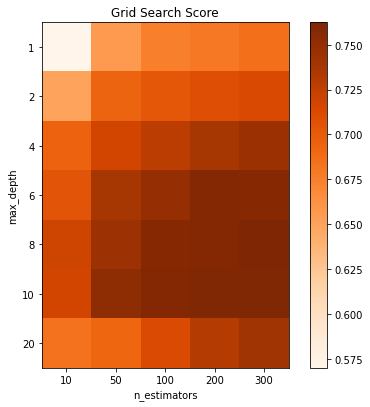

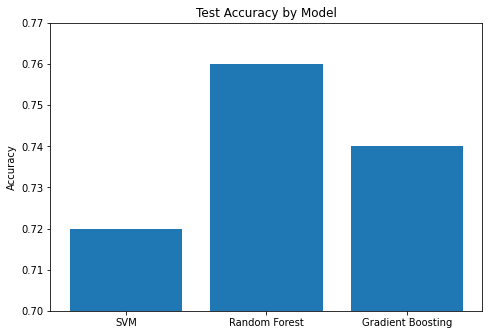

In [41]:
scores = grid.cv_results_['mean_test_score'].reshape(len(max_depthRange),len(numTreesRange))
print(scores)
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Oranges)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(numTreesRange)), numTreesRange)
plt.yticks(np.arange(len(max_depthRange)), max_depthRange)
plt.title('Grid Search Score')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ker = ['SVM', 'Random Forest', 'Gradient Boosting']
kerVals = [.720001,.76, .74]
plt.ylabel('Accuracy')
plt.title('Test Accuracy by Model')
ax.set_ylim([.7, .77])
ax.bar(ker,kerVals)
plt.show()



